### NLTGCR optimizer

In [1]:
import torch
from functools import reduce
from torch.optim.optimizer import Optimizer
from torch.nn.functional import normalize

def _cubic_interpolate(x1, f1, g1, x2, f2, g2, bounds=None):
    # ported from https://github.com/torch/optim/blob/master/polyinterp.lua
    # Compute bounds of interpolation area
    if bounds is not None:
        xmin_bound, xmax_bound = bounds
    else:
        xmin_bound, xmax_bound = (x1, x2) if x1 <= x2 else (x2, x1)

    # Code for most common case: cubic interpolation of 2 points
    #   w/ function and derivative values for both
    # Solution in this case (where x2 is the farthest point):
    #   d1 = g1 + g2 - 3*(f1-f2)/(x1-x2);
    #   d2 = sqrt(d1^2 - g1*g2);
    #   min_pos = x2 - (x2 - x1)*((g2 + d2 - d1)/(g2 - g1 + 2*d2));
    #   t_new = min(max(min_pos,xmin_bound),xmax_bound);
    d1 = g1 + g2 - 3 * (f1 - f2) / (x1 - x2)
    d2_square = d1**2 - g1 * g2
    if d2_square >= 0:
        d2 = d2_square.sqrt()
        if x1 <= x2:
            min_pos = x2 - (x2 - x1) * ((g2 + d2 - d1) / (g2 - g1 + 2 * d2))
        else:
            min_pos = x1 - (x1 - x2) * ((g1 + d2 - d1) / (g1 - g2 + 2 * d2))
        return min(max(min_pos, xmin_bound), xmax_bound)
    else:
        return (xmin_bound + xmax_bound) / 2.
    
def _simple_wolfe(obj_func,
                  reset_func,
                 x,
                 t,
                 d,
                 f,
                 g,
                 c1=1e-4,
                 c2=0.9,
                 max_ls=5,
                 ):
    # parameters for Wolfe criteria
    f_prev = f
    g_prev = g.clone(memory_format=torch.contiguous_format)
    gtd_prev = g_prev.dot(d)
    
    # line search
    alpha = 1.0 # factor on step size
    ls_iter = 0 # num. of line search iterations
    done = False # both conditions satisfied?
    while ls_iter < max_ls:
        ls_iter += 1
        # evaluate objective and gradient using step size lam*t
        f_new, g_new = obj_func(x, alpha * t, d)
        # Armijo rule
        Armijo_cond = f_new < f_prev + c1 * alpha * t * gtd_prev
        # curvature condition
        gtd_new = g_new.dot(d)
        curvature_cond = gtd_new.abs() < c2 * gtd_prev.abs()
        # check Wolfe conditions
        if Armijo_cond and curvature_cond:
            done = True
            break
        else:
            #alpha *= 0.5
            alpha = _cubic_interpolate(0., f_prev, gtd_prev, alpha, f_new, gtd_new, bounds=None)
            if alpha == 0.:
                break
    
    if done:
        #print(f'Wolfe criteria passes in {ls_iter} steps')
        return f_new, g_new, alpha * t, ls_iter
    else:
        #print(f'No move, break in {ls_iter} steps')
        reset_func(g_prev)
        return f_prev, g_prev, 0., ls_iter


class NLTGCR(Optimizer):
    """Implements nlTGCR algorithm, inspired by the implementation of L-BFGS in
    PyTorch.

    .. warning::
        This optimizer doesn't support per-parameter options and parameter
        groups (there can be only one).

    .. warning::
        Right now all parameters have to be on a single device. This will be
        improved in the future.

    .. note::
        This is a very memory intensive optimizer (it requires additional
        ``param_bytes * (history_size + 1)`` bytes). If it doesn't fit in memory
        try reducing the history size, or use a different algorithm.

    Args:
        lr (float): learning rate (default: 1)
        max_iter (int): maximal number of iterations per optimization step
            (default: 5)
        max_eval (int): maximal number of function evaluations per optimization
            step (default: max_iter * 2).
        restart (int): maximal number of iterations before restart (default: 10)
        tolerance_grad (float): termination tolerance on first order optimality
            (default: 1e-5).
        tolerance_change (float): termination tolerance on function
            value/parameter changes (default: 1e-9).
        history_size (int): update history size (default: 5).
        option (str): support 'one_vector', 'linear', and None (default: None)
        adaptive (bool): automatically change to 'linear' option (default: False)
        strategy (str): support 'line_search', 'trust_region', and None (default: None).
    """

    def __init__(self,
                 params,
                 lr=1,
                 max_iter=5,
                 max_eval=None,
                 restart=10,
                 tolerance_grad=1e-5,
                 tolerance_change=1e-9,
                 history_size=5,
                 option=None,
                 adaptive=False,
                 strategy=None,
                ):
        if max_eval is None:
            max_eval = max_iter * 2
        defaults = dict(
            lr=lr,
            max_iter=max_iter,
            max_eval=max_eval,
            restart=restart,
            tolerance_grad=tolerance_grad,
            tolerance_change=tolerance_change,
            history_size=history_size,
            option=option,
            adaptive=adaptive,
            strategy=strategy)
        super(NLTGCR, self).__init__(params, defaults)

        if len(self.param_groups) != 1:
            raise ValueError("nlTGCR doesn't support per-parameter options "
                             "(parameter groups)")

        self._params = self.param_groups[0]['params']
        self._numel_cache = None

    def _numel(self):
        if self._numel_cache is None:
            self._numel_cache = reduce(lambda total, p: total + p.numel(), self._params, 0)
        return self._numel_cache

    def _gather_flat_grad(self):
        """Returns the gradient in flat view
        """
        views = []
        for p in self._params:
            if p.grad is None:
                view = p.new(p.numel()).zero_()
            elif p.grad.is_sparse:
                p.grad = normalize(p.grad, p=2.0, dim=0)
                view = p.grad.to_dense().view(-1)
            else:
                p.grad = normalize(p.grad, p=2.0, dim=0)
                view = p.grad.view(-1)
            views.append(view)
        return torch.cat(views, 0)

    def _add_grad(self, step_size, update):
        """Computes x <- x + step_size * update
        """
        offset = 0
        for p in self._params:
            numel = p.numel()
            # view as to avoid deprecated pointwise semantics
            p.add_(update[offset:offset + numel].view_as(p), alpha=step_size)
            offset += numel
        assert offset == self._numel()

    def _clone_param(self):
        return [p.clone(memory_format=torch.contiguous_format) for p in self._params]

    def _set_param(self, params_data):
        for p, pdata in zip(self._params, params_data):
            p.copy_(pdata)
            
    def _max_param(self, params_data):
        p_max = 0
        for p in params_data:
            tmp_max = p.abs().max()
            if p_max < tmp_max:
                p_max = tmp_max
        return p_max

    def combine(self):
        vl = []
        for p in self._params:
            if p.requires_grad:
                v = p.data.view(-1)
                vl.append(v)
        fp = torch.cat(vl)    
        return fp.norm()
    
    def _set_grad(self, grad_data):
        offset = 0
        for p in self._params:
            numel = p.numel()
            # view as to avoid deprecated pointwise semantics
            p.grad.copy_(grad_data[offset:offset + numel].view_as(p))
            offset += numel
        assert offset == self._numel()

    def _directional_evaluate(self, closure, x, prev_grad, step_size, update):
        """Returns loss and gradient at x + step_size * update
            without updating x
        """
        # compute loss and gradient at x + step_size * update
        self._add_grad(step_size, update)
        loss = float(closure())
        flat_grad = self._gather_flat_grad()
        # reset x and grad
        self._set_param(x)
        self._set_grad(prev_grad)
        return loss, flat_grad
    
    def _directional_evaluate_no_reset(self, closure, x, t, d):
        self._add_grad(t, d)
        loss = float(closure())
        flat_grad = self._gather_flat_grad()
        self._set_param(x)
        return loss, flat_grad
    
    def _hessian_evaluate(self, closure, x, g, r):
        """Computes H(x)*r where the Hessian is built implicitly using
            Frechet derivative H(x)*r = (F(x + ep*r) - F(x))/ep.
            
        Args:
            closure (callable): a model that returns current loss f(x).
            x (tensor): point to evaluate.
            r (tensor): vector to multiply with Hessian
        """
        # NOTE: extremely small ep may cause stability issue
        F0 = g
        # ep = self._max_param(x) / (r.abs().max() + 1e-16) * 1e-8
        # ep = r.abs().max()
        ep = 1 * r.norm()/ self.combine()
        _,F1 = self._directional_evaluate(closure, x, g, ep, r)
        #_,F1 = self._directional_evaluate(closure, x, g, ep * 1.j, r)
        return (F1 - F0)/ep
        #return F1.imag / ep
        

    @torch.no_grad()
    def step(self, closure):
        """Performs a single optimization step.

        Args:
            closure (callable): A closure that reevaluates the model
                and returns the loss.
        """
        assert len(self.param_groups) == 1

        # Make sure the closure is always called with grad enabled
        closure = torch.enable_grad()(closure)

        group = self.param_groups[0]
        lr = group['lr']
        max_iter = group['max_iter']
        max_eval = group['max_eval']
        restart = group['restart']
        tolerance_grad = group['tolerance_grad']
        tolerance_change = group['tolerance_change']
        history_size = group['history_size']
        option = group['option']
        adaptive = group['adaptive']
        strategy = group['strategy']

        # NOTE: nlTGCR has only global state, but we register it as state for
        # the first param, because this helps with casting in load_state_dict
        state = self.state[self._params[0]]
        state.setdefault('func_evals', 0)
        state.setdefault('n_iter', 0)
        state.setdefault('n_restart', 0)
        state.setdefault('init_rho', 0.0)
        state.setdefault('ep', None)

        # evaluate initial f(x) and df/dx
        orig_loss = closure()
        loss = float(orig_loss)
        flat_grad = self._gather_flat_grad()
        current_evals = 1
        state['func_evals'] += 1

        # check if initial state has already converged
        opt_cond = flat_grad.abs().max() <= tolerance_grad
        if opt_cond:
            return orig_loss

        # tensors cached in state (for tracing)
        old_v = state.get('old_v')
        old_p = state.get('old_p')
        r = state.get('res')
        t = state.get('stepsize')
        y = state.get('y')
        prev_flat_grad = state.get('prev_flat_grad')
        prev_loss = state.get('prev_loss')
        prev_r = state.get('res')
        rho0 = state.get('init_rho')

        n_iter = 0 # num. of global iterations
        while n_iter < max_iter:
            # keep track of num. of iterations
            n_iter += 1
            state['n_iter'] += 1
            state['n_restart'] += 1
            # trigger a restart at the first iteration of each restart period
            if state['n_restart'] % restart == 1:
                restart_cond = True # switch restart mode to on
                state['n_restart'] = 1
            else:
                # switch restart mode to off
                restart_cond = False
            
            ############################################################
            # update residual
            ############################################################
            if option == "linear" and not restart_cond:
                r.add_(old_v[-1], alpha=-t * y) # linear update: r <- r - stepsize * y * v
            else:
                r = flat_grad.neg()  # r = -grad(f(x))
            p = r.clone(memory_format=torch.contiguous_format)
            v = self._hessian_evaluate(closure, 
                                   self._clone_param(), 
                                   flat_grad.clone(memory_format=torch.contiguous_format),
                                   r.clone(memory_format=torch.contiguous_format),
                                  ) # v <- H(x) * r
            state['func_evals'] += 1 # one func and grad eval in self.Hesssian_evaluate
                
            ############################################################
            # adaptive residual tracking
            ############################################################
            if adaptive:
                if restart_cond:
                    r_lin = r.clone(memory_format=torch.contiguous_format)
                else:
                    r_lin = prev_r.add(old_v[-1], alpha=-t * y) # linear update: r <- r - stepsize * y * v
                    # compute cosine distance between r and r_lin
                    dist = r_lin.dot(r)/torch.norm(r)/torch.norm(r_lin)
                    #print(f'dist = {dist}')
                    if dist.abs() <= 0.001:
                        print('change to linear updating')
                        option = "linear"
                #print(f'it = {n_iter}, option = {option}')
                
            ############################################################
            # compute descent direction
            ############################################################
            if restart_cond:
                # NOTE: may lead to stability issue when v close to 0
                rho0 = torch.norm(v)
                old_v = [v.mul(1./rho0)] # v <- v / norm(v), then initialize V = [v]
                old_p = [p.mul(1./rho0)] # p <- v / norm(v), then initialize P = [p]
                
                # descent direction
                y = old_v[0].dot(r) # y = V' * r
                d = old_p[0].mul(y) # d = P * y

            else:
                # partial orthogonalization
                num_old = len(old_v)
                for i in range(num_old):
                    beta = old_v[i].dot(v)        # beta_i = dot(V_i, v)
                    p.add_(old_p[i], alpha=-beta) # p <- p - beta_i * P_i
                    v.add_(old_v[i], alpha=-beta) # v <- v - beta_i * V_i
                
                rho = torch.norm(v)
                if rho > tolerance_grad * rho0: # v is not dependent
                    # updating memory
                    if num_old == history_size:
                        # shift history by one (limited-memory)
                        old_p.pop(0)
                        old_v.pop(0)

                    # store new p and v
                    rho = 1. / rho
                    old_p.append(p.mul(rho)) # append p / norm(v) to P
                    old_v.append(v.mul(rho)) # append v / norm(v) to V
                else:
                    # if v becomes dependent, restart
                    state['n_restart'] = 0
                    print('restart')
                    continue
                
                # descent direction
                if option is not None:   # only use one vector if option is 'one_vector' or 'linear'
                    y = old_v[-1].dot(r) # y = V_n * r
                    d = old_p[-1].mul(y) # d = P_n * y
                else: # use all stored vectors
                    num_old = len(old_v)
                    #d = torch.zeros(p.size())
                    d = old_p[0].mul(old_v[0].dot(r))
                    for i in range(1,num_old):
                        y = old_v[i].dot(r)       # y_i = V_i * r
                        d.add_(old_p[i], alpha=y) # d <- d + P_i * y_i

            if prev_flat_grad is None:
                prev_flat_grad = flat_grad.clone(memory_format=torch.contiguous_format)
            else:
                prev_flat_grad.copy_(flat_grad)
            prev_loss = loss
            prev_r = r.clone(memory_format=torch.contiguous_format)
            
            ############################################################
            # normalize descent direction
            ############################################################
            # NOTE: d can be extremely small
            # dscal = 1./torch.norm(d)
            # d = d.mul(dscal)
            d = normalize(d, p=2.0, dim=0)
            # NOTE: if d is not descent
            gtd = prev_flat_grad.dot(d)
            if gtd > 0:
                d = -d

            ############################################################
            # compute step length
            ############################################################
            # reset initial guess for step size
            t = torch.tensor(lr).to(device)

            # optional global convergence strategy
            strategy_func_evals = 0
            if strategy is not None:
                # perform line search
                if strategy == "line_search":
                    x_init = self._clone_param()

                    def obj_func(x, t, d):
                        return self._directional_evaluate_no_reset(closure, x, t, d)
                    
                    def reset_func(g):
                        return self._set_grad(g)

                    loss, flat_grad, t, strategy_func_evals = _simple_wolfe(
                        obj_func, reset_func, x_init, t, d, loss, flat_grad)
                    self._add_grad(t, d)
                    opt_cond = flat_grad.abs().max() <= tolerance_grad
                # perform trust region
                elif strategy == "trust_region":
                    raise RuntimeError("'trust_region' is not implemented yet")
                else:
                    raise RuntimeError("only 'line_search' and 'trust_region' are supported")
            else:
                # update x and gradient
                self._add_grad(t, d)
                if n_iter < max_iter and not option == "linear":
                    loss = float(closure())
                    flat_grad = self._gather_flat_grad()
                    opt_cond = flat_grad.abs().max() <= tolerance_grad
                    strategy_func_evals += 1

            # update func eval
            current_evals += strategy_func_evals
            state['func_evals'] += strategy_func_evals
            
            #print(f"it = {state.get('n_iter')}")
            #print(f'x = {self._clone_param()}')
            #print(f'r = {r}')
            #print(f'old_p = {old_p}')
            #print(f'old_v = {old_v}')
            #print(f'd = {d}')
            #print(f'gtd = {d.dot(prev_flat_grad)}')
            #print(f't = {t}')
            #print(f'loss = {loss}')
            
            ############################################################
            # check conditions
            ############################################################
            if n_iter == max_iter:
                break

            if current_evals >= max_eval:
                break

            # optimal condition
            if opt_cond:
                break

            # lack of progress
            if d.mul(t).abs().max() <= tolerance_change:
                break

            if abs(loss - prev_loss) < tolerance_change:
                break
            
        state['old_p'] = old_p
        state['old_v'] = old_v
        state['res'] = r
        state['stepsize'] = t
        state['y'] = y
        state['prev_flat_grad'] = prev_flat_grad
        state['prev_loss'] = prev_loss
        state['init_rho'] = rho0

        return orig_loss

### some imports

In [3]:
from typing import Callable, List, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torch_geometric
import torch_geometric.transforms as T
from torch import Tensor
from torch.optim import Optimizer
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from typing_extensions import Literal, TypedDict

In [4]:
import time

### Cora dataset

Tutorial comes from https://blog.devgenius.io/how-to-train-a-graph-convolutional-network-on-the-cora-dataset-with-pytorch-geometric-847ed5fab9cb

In [5]:
dataset = Planetoid("./files/Cora", name="Cora", transform=T.NormalizeFeatures())
num_nodes = dataset.data.num_nodes
num_edges = dataset.data.num_edges // 2
train_len = dataset[0].train_mask.sum()
val_len = dataset[0].val_mask.sum()
test_len = dataset[0].test_mask.sum()
other_len = num_nodes - train_len - val_len - test_len
print(f"Dataset: {dataset.name}")
print(f"Num. nodes: {num_nodes} (train={train_len}, val={val_len}, test={test_len}, other={other_len})")
print(f"Num. edges: {num_edges}")
print(f"Num. node features: {dataset.num_node_features}")
print(f"Num. classes: {dataset.num_classes}")
print(f"Num. dataset: {dataset.len()}")

Processing...


Dataset: Cora
Num. nodes: 2708 (train=140, val=500, test=1000, other=1068)
Num. edges: 5278
Num. node features: 1433
Num. classes: 7
Num. dataset: 1


Done!
c:\Users\Huan\miniconda3\envs\torch-cuda\lib\site-packages\torch_geometric\data\in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


### Graph Convolutional Networks

In [6]:


class GCN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes,hidden_dim=128,dropout_rate=0.2):
        super().__init__()
        self.conv1 = GCNConv(num_node_features, 16)
        self.conv2 = GCNConv(16, num_classes)
        self.dropout1 = torch.nn.Dropout(dropout_rate)
        self.dp = dropout_rate
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x,0.5 ,training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

### Training and evaluation

In [7]:
LossFn = Callable[[Tensor, Tensor], Tensor]
Stage = Literal["train", "val", "test"]

def accuracy(pred: Tensor, target: Tensor) -> float:
    return (pred == target).sum().item() / target.numel()

def train_step(
    model: torch.nn.Module, data: Data, optimizer: torch.optim.Optimizer, loss_fn: LossFn
) -> Tuple[float, float]:
    model.train()
    mask = data.train_mask
    def closure(nargout=1):
        optimizer.zero_grad()
        logits = model(data.x, data.edge_index)[mask]
        preds = logits.argmax(dim=1)
        y = data.y[mask]
        acc = accuracy(preds, y)
        loss = loss_fn(logits, y)
        # loss = loss_fn(logits, y)
        loss.backward(create_graph = True)
        if nargout == 1:
            return loss
        else:
            return loss, acc
    loss, acc = closure(nargout=2)
    optimizer.step(closure)
    return loss.item(), acc

@torch.no_grad()
def eval_step(model: torch.nn.Module, data: Data, loss_fn: LossFn, stage: Stage) -> Tuple[float, float]:
    model.eval()
    mask = getattr(data, f"{stage}_mask")
    logits = model(data.x, data.edge_index)[mask]
    preds = logits.argmax(dim=1)
    y = data.y[mask]
    acc = accuracy(preds, y)
    loss = loss_fn(logits, y)
    return loss.item(), acc

In [8]:
class HistoryDict(TypedDict):
    loss: List[float]
    acc: List[float]
    val_loss: List[float]
    val_acc: List[float]
        
def train(
    model: torch.nn.Module,
    data: Data,
    optimizer: torch.optim.Optimizer,
    loss_fn: LossFn = torch.nn.CrossEntropyLoss(),
    # loss_fn: LossFn = F.nll_loss(),
    max_epochs: int = 200,
    early_stopping: int = 10,
    print_interval: int = 100,
    verbose: bool = True,
) -> HistoryDict:
    history = {"loss": [], "acc": [], "val_loss": [],  "val_acc": []}
    best_acc = 0

    for epoch in range(max_epochs):
        loss, acc = train_step(model, data, optimizer, loss_fn)
        val_loss, val_acc = eval_step(model, data, loss_fn, "val")
        if val_acc>best_acc:
            best_acc=val_acc
            bmodel = model
            test_loss, test_acc = eval_step(bmodel, data, loss_fn, "test")
        # if epoch > early_stopping and val_loss > np.mean(history["val_loss"][-(early_stopping + 1) : -1]):
        #     if verbose:
        #         print("\nEarly stopping...")
        #     break
        history["loss"].append(loss)
        history["acc"].append(acc)
        history["val_loss"].append(test_loss)
        history["val_acc"].append(test_acc)
        if verbose and epoch % print_interval == 0:
            print(f"\nEpoch: {epoch}\n----------")
            print(f"Train loss: {loss:.4f} | Train acc: {acc:.4f}")
            print(f"  Val loss: {val_loss:.4f} |   Val acc: {val_acc:.4f}")
            
    test_loss, test_acc = eval_step(model, data, loss_fn, "test")
    if verbose:
        print(f"\nEpoch: {epoch}\n----------")
        print(f"Train loss: {loss:.4f} | Train acc: {acc:.4f}")
        print(f"  Val loss: {val_loss:.4f} |   Val acc: {val_acc:.4f}")
        print(f" Test loss: {test_loss:.4f} |  Test acc: {test_acc:.4f}")
        
    return history

In [9]:
def plot_history(history: HistoryDict, title: Optional[str] = None, font_size: Optional[int] = 14) -> None:
    if title is not None:
        plt.suptitle(title, fontsize=font_size)
    ax1 = plt.subplot(1,2,1)
    ax1.set_title("Loss")
    ax1.plot(history["loss"], label="train")
    ax1.plot(history["val_loss"], label="val")
    plt.xlabel("Epoch")
    ax1.legend()
    
    ax2 = plt.subplot(1,2,2)
    ax2.set_title("Accuracy")
    ax2.plot(history["acc"], label="train")
    ax2.plot(history["val_acc"], label="val")
    plt.xlabel("Epoch")
    ax2.legend()

### Train the model

In [10]:
SEED = 888
MAX_EPOCHS = 800
EARLY_STOPPING = 100

torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device='cpu'

##### NLTGCR (m = 1)

In [27]:
model = GCN(dataset.num_node_features, dataset.num_classes)
print(model)
data = dataset[0]

optimizer = NLTGCR(
                 model.parameters(),
                 max_iter=1,
                 max_eval=999,
                 restart=5,
                 history_size=1,
                 strategy=None,
            )

print(optimizer)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
  (dropout1): Dropout(p=0.2, inplace=False)
)
NLTGCR (
Parameter Group 0
    adaptive: False
    history_size: 1
    lr: 1
    max_eval: 999
    max_iter: 1
    option: None
    restart: 5
    strategy: None
    tolerance_change: 1e-09
    tolerance_grad: 1e-05
)


In [28]:
start = time.time()
history_nltgcr1 = train(
            model.to(device), 
            data.to(device), 
            optimizer,
            max_epochs=MAX_EPOCHS,
            early_stopping=EARLY_STOPPING,
            )
nltime = time.time()-start


Epoch: 0
----------
Train loss: 1.9458 | Train acc: 0.0929
  Val loss: 1.9459 |   Val acc: 0.3240

Epoch: 100
----------
Train loss: 0.2813 | Train acc: 0.9714
  Val loss: 0.8157 |   Val acc: 0.7840

Epoch: 200
----------
Train loss: 0.0151 | Train acc: 1.0000
  Val loss: 0.7320 |   Val acc: 0.7820

Epoch: 300
----------
Train loss: 0.0135 | Train acc: 0.9929
  Val loss: 0.9166 |   Val acc: 0.7680

Epoch: 400
----------
Train loss: 0.0099 | Train acc: 1.0000
  Val loss: 1.1376 |   Val acc: 0.7620

Epoch: 500
----------
Train loss: 0.0063 | Train acc: 1.0000
  Val loss: 1.2407 |   Val acc: 0.7460

Epoch: 600
----------
Train loss: 0.0024 | Train acc: 1.0000
  Val loss: 1.4192 |   Val acc: 0.7540

Epoch: 700
----------
Train loss: 0.0009 | Train acc: 1.0000
  Val loss: 1.5685 |   Val acc: 0.7520

Epoch: 799
----------
Train loss: 0.0007 | Train acc: 1.0000
  Val loss: 1.7550 |   Val acc: 0.7500
 Test loss: 1.5664 |  Test acc: 0.7680


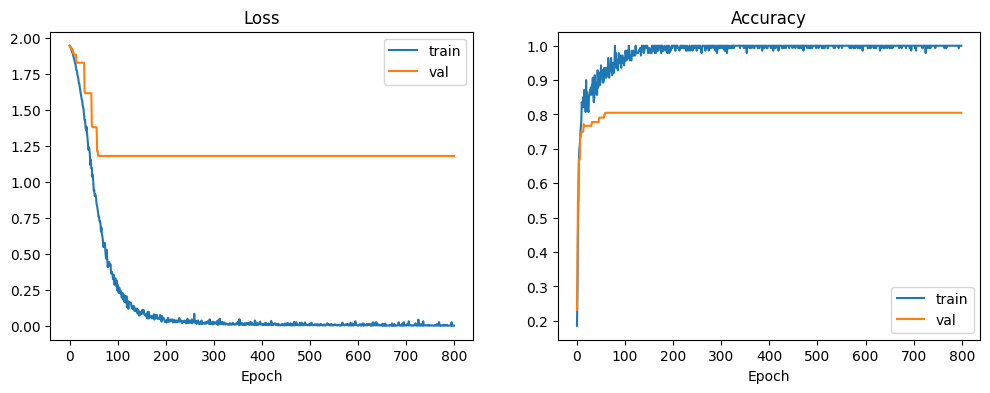

In [72]:
plt.figure(figsize=(12, 4))
plot_history(history_nltgcr1)

##### NLTGCR (m = 10)

In [14]:
model = GCN(dataset.num_node_features, dataset.num_classes)
print(model)
data = dataset[0]

optimizer = NLTGCR(
                 model.parameters(),
                 lr=1.0,
                 max_iter=1,
                 max_eval=999,
                 restart=15,
                 history_size=10,
                 strategy=None,
            )

print(optimizer)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
  (dropout1): Dropout(p=0.2, inplace=False)
)
NLTGCR (
Parameter Group 0
    adaptive: False
    history_size: 10
    lr: 1.0
    max_eval: 999
    max_iter: 1
    option: None
    restart: 15
    strategy: None
    tolerance_change: 1e-09
    tolerance_grad: 1e-05
)


In [15]:
history_nltgcr2 = train(
            model.to(device), 
            data.to(device), 
            optimizer,
            max_epochs=MAX_EPOCHS,
            early_stopping=EARLY_STOPPING,
            )


Epoch: 0
----------
Train loss: 1.9453 | Train acc: 0.1714
  Val loss: 1.9419 |   Val acc: 0.3700

Epoch: 100
----------
Train loss: 0.1971 | Train acc: 0.9857
  Val loss: 0.7618 |   Val acc: 0.7820

Epoch: 200
----------
Train loss: 0.0395 | Train acc: 0.9929
  Val loss: 0.7817 |   Val acc: 0.7860

Epoch: 300
----------
Train loss: 0.0102 | Train acc: 1.0000
  Val loss: 0.9782 |   Val acc: 0.7700

Epoch: 400
----------
Train loss: 0.0023 | Train acc: 1.0000
  Val loss: 1.1808 |   Val acc: 0.7700

Epoch: 500
----------
Train loss: 0.0126 | Train acc: 0.9929
  Val loss: 1.3212 |   Val acc: 0.7720

Epoch: 600
----------
Train loss: 0.0016 | Train acc: 1.0000
  Val loss: 1.5138 |   Val acc: 0.7600

Epoch: 700
----------
Train loss: 0.0001 | Train acc: 1.0000
  Val loss: 1.6301 |   Val acc: 0.7640

Epoch: 799
----------
Train loss: 0.0066 | Train acc: 0.9929
  Val loss: 1.8188 |   Val acc: 0.7560
 Test loss: 1.6308 |  Test acc: 0.7830


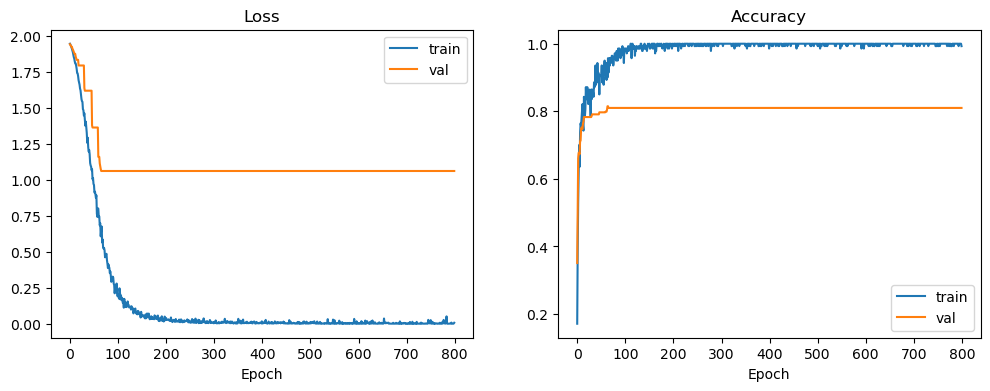

In [16]:
plt.figure(figsize=(12, 4))
plot_history(history_nltgcr2)

##### Adam (lr = 0.01)

In [17]:
model = GCN(dataset.num_node_features, dataset.num_classes)
print(model)
data = dataset[0]

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

print(optimizer)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
  (dropout1): Dropout(p=0.2, inplace=False)
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)


In [18]:
history_adam1 = train(
            model.to(device), 
            data.to(device), 
            optimizer,
            max_epochs=MAX_EPOCHS,
            early_stopping=EARLY_STOPPING,
            )


Epoch: 0
----------
Train loss: 1.9463 | Train acc: 0.1286
  Val loss: 1.9457 |   Val acc: 0.2560

Epoch: 100
----------
Train loss: 0.1747 | Train acc: 1.0000
  Val loss: 0.8128 |   Val acc: 0.7860

Epoch: 200
----------
Train loss: 0.0455 | Train acc: 0.9929
  Val loss: 0.7578 |   Val acc: 0.7820

Epoch: 300
----------
Train loss: 0.0293 | Train acc: 1.0000
  Val loss: 0.8215 |   Val acc: 0.7660

Epoch: 400
----------
Train loss: 0.0162 | Train acc: 1.0000
  Val loss: 0.8487 |   Val acc: 0.7780

Epoch: 500
----------
Train loss: 0.0111 | Train acc: 1.0000
  Val loss: 0.8900 |   Val acc: 0.7720

Epoch: 600
----------
Train loss: 0.0135 | Train acc: 1.0000
  Val loss: 0.9315 |   Val acc: 0.7700

Epoch: 700
----------
Train loss: 0.0130 | Train acc: 0.9929
  Val loss: 0.9474 |   Val acc: 0.7720

Epoch: 799
----------
Train loss: 0.0180 | Train acc: 0.9929
  Val loss: 0.9723 |   Val acc: 0.7720
 Test loss: 0.9044 |  Test acc: 0.7790


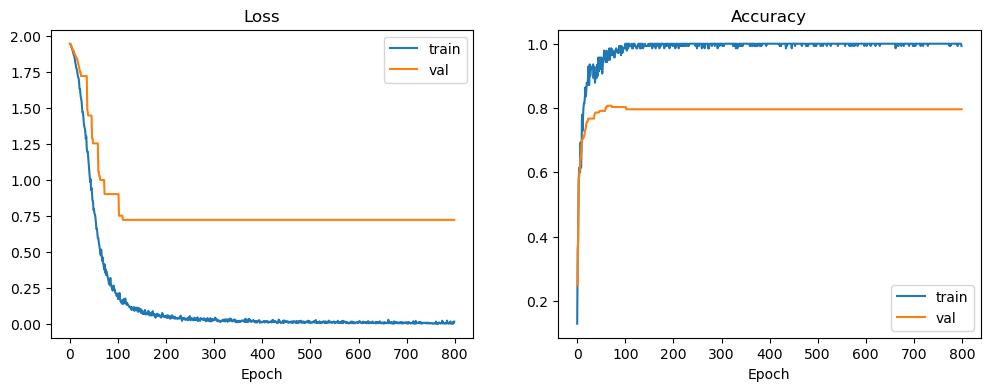

In [19]:
plt.figure(figsize=(12, 4))
plot_history(history_adam1)

##### Adam (lr = 0.001)

In [20]:
model = GCN(dataset.num_node_features, dataset.num_classes)
print(model)
data = dataset[0]

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(optimizer)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
  (dropout1): Dropout(p=0.2, inplace=False)
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


In [21]:
history_adam2 = train(
            model.to(device), 
            data.to(device), 
            optimizer,
            max_epochs=MAX_EPOCHS,
            early_stopping=EARLY_STOPPING,
            )


Epoch: 0
----------
Train loss: 1.9456 | Train acc: 0.1357
  Val loss: 1.9452 |   Val acc: 0.1500

Epoch: 100
----------
Train loss: 1.7564 | Train acc: 0.8429
  Val loss: 1.8471 |   Val acc: 0.7020

Epoch: 200
----------
Train loss: 1.4314 | Train acc: 0.9214
  Val loss: 1.6724 |   Val acc: 0.7500

Epoch: 300
----------
Train loss: 1.0985 | Train acc: 0.9000
  Val loss: 1.4564 |   Val acc: 0.7720

Epoch: 400
----------
Train loss: 0.8275 | Train acc: 0.9071
  Val loss: 1.2554 |   Val acc: 0.7720

Epoch: 500
----------
Train loss: 0.5933 | Train acc: 0.9500
  Val loss: 1.0937 |   Val acc: 0.7820

Epoch: 600
----------
Train loss: 0.4684 | Train acc: 0.9571
  Val loss: 0.9817 |   Val acc: 0.7800

Epoch: 700
----------
Train loss: 0.3358 | Train acc: 0.9643
  Val loss: 0.8988 |   Val acc: 0.7880

Epoch: 799
----------
Train loss: 0.2669 | Train acc: 0.9857
  Val loss: 0.8463 |   Val acc: 0.7940
 Test loss: 0.7978 |  Test acc: 0.8010


##### Results

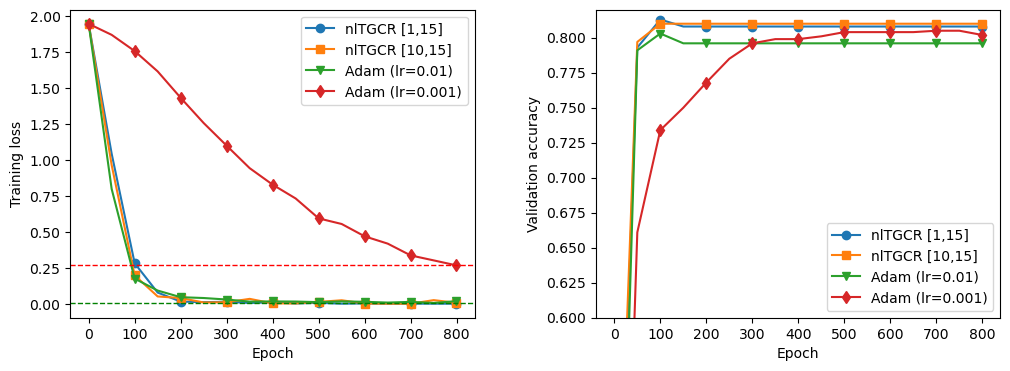

In [30]:
import matplotlib.pyplot as plt
plt_intv = 50

# Load history
l = len(history_adam1["val_loss"])
idx_adam1 = [i for i in range(0,l,plt_intv)]
idx_adam1.append(l-1)
loss_adam1 = [history_adam1["loss"][i] for i in idx_adam1]
acc_adam1 = [history_adam1["val_acc"][i] for i in idx_adam1]




l = len(history_adam2["val_loss"])
idx_adam2 = [i for i in range(0,l,plt_intv)]
idx_adam2.append(l-1)
loss_adam2 = [history_adam2["loss"][i] for i in idx_adam2]
acc_adam2 = [history_adam2["val_acc"][i] for i in idx_adam2]

l = len(history_nltgcr1["val_loss"])
idx_nltgcr1 = [i for i in range(0,l,plt_intv)]
idx_nltgcr1.append(l-1)
loss_nltgcr1 = [history_nltgcr1["loss"][i] for i in idx_nltgcr1]
acc_nltgcr1 = [history_nltgcr1["val_acc"][i] for i in idx_nltgcr1]

l = len(history_nltgcr2["val_loss"])
idx_nltgcr2 = [i for i in range(0,l,plt_intv)]
idx_nltgcr2.append(l-1)
loss_nltgcr2 = [history_nltgcr2["loss"][i] for i in idx_nltgcr2]
acc_nltgcr2 = [history_nltgcr2["val_acc"][i] for i in idx_nltgcr2]


me=2
# Plotting
fig1 = plt.figure(figsize=(12, 4))
plt.subplots_adjust(wspace=0.3)

ax1 = plt.subplot(1,2,1)
ax1.plot(idx_nltgcr1, loss_nltgcr1, label="nlTGCR [1,15]", color='tab:blue', marker="o",markevery=me)
ax1.plot(idx_nltgcr2, loss_nltgcr2, label="nlTGCR [10,15]", color='tab:orange', marker="s",markevery=me)
ax1.plot(idx_adam1, loss_adam1, label="Adam (lr=0.01)", color='tab:green', marker="v",markevery=me)
ax1.plot(idx_adam2, loss_adam2, label="Adam (lr=0.001)", color='tab:red', marker="d",markevery=me)
plt.xlabel("Epoch")
plt.ylabel("Training loss")
plt.axhline(y = min(history_adam1["loss"]), color = 'green', linestyle = '--', linewidth = 1)
plt.axhline(y = min(history_adam2["loss"]), color = 'red', linestyle = '--', linewidth = 1)
#plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
ax1.legend(loc="upper right")

ax2 = plt.subplot(1,2,2)
ax2.plot(idx_nltgcr1, acc_nltgcr1, label="nlTGCR [1,15]", color='tab:blue', marker="o",markevery=me)
ax2.plot(idx_nltgcr2, acc_nltgcr2, label="nlTGCR [10,15]", color='tab:orange', marker="s",markevery=me)
ax2.plot(idx_adam1, acc_adam1, label="Adam (lr=0.01)", color='tab:green', marker="v",markevery=me)
ax2.plot(idx_adam2, acc_adam2, label="Adam (lr=0.001)", color='tab:red', marker="d",markevery=me)

plt.xlabel("Epoch")
plt.ylabel("Validation accuracy")
plt.ylim([0.6, 0.82])
#plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
ax2.legend(loc="best")

In [ ]:
print("test 1")
print("                   train loss | train acc | val loss | val acc")
print(f'nlTGCR [5,15]  |   {min(history_nltgcr1["loss"]):.4f}     | {max(history_nltgcr1["acc"]):.4f}    | {min(history_nltgcr1["val_loss"]):.4f}   | {max(history_nltgcr1["val_acc"]):.4f}')
print(f'nlTGCR [15,15] |   {min(history_nltgcr2["loss"]):.4f}     | {max(history_nltgcr2["acc"]):.4f}    | {min(history_nltgcr2["val_loss"]):.4f}   | {max(history_nltgcr2["val_acc"]):.4f}')
print(f'Adam (lr=0.01) |   {min(history_adam1["loss"]):.4f}     | {max(history_adam1["acc"]):.4f}    | {min(history_adam1["val_loss"]):.4f}   | {max(history_adam1["val_acc"]):.4f}')
print(f'Adam (lr=0.001)|   {min(history_adam2["loss"]):.4f}     | {max(history_adam2["acc"]):.4f}    | {min(history_adam2["val_loss"]):.4f}   | {max(history_adam2["val_acc"]):.4f}')

In [ ]:
print("test 2")
print("                   train loss | train acc | val loss | val acc")
print(f'nlTGCR [5,15]  |   {min(history_nltgcr1["loss"]):.4f}     | {max(history_nltgcr1["acc"]):.4f}    | {min(history_nltgcr1["val_loss"]):.4f}   | {max(history_nltgcr1["val_acc"]):.4f}')
print(f'nlTGCR [15,15] |   {min(history_nltgcr2["loss"]):.4f}     | {max(history_nltgcr2["acc"]):.4f}    | {min(history_nltgcr2["val_loss"]):.4f}   | {max(history_nltgcr2["val_acc"]):.4f}')
print(f'Adam (lr=0.01) |   {min(history_adam1["loss"]):.4f}     | {max(history_adam1["acc"]):.4f}    | {min(history_adam1["val_loss"]):.4f}   | {max(history_adam1["val_acc"]):.4f}')
print(f'Adam (lr=0.001)|   {min(history_adam2["loss"]):.4f}     | {max(history_adam2["acc"]):.4f}    | {min(history_adam2["val_loss"]):.4f}   | {max(history_adam2["val_acc"]):.4f}')

In [ ]:
print("test 3")
print("                   train loss | train acc | val loss | val acc")
print(f'nlTGCR [5,15]  |   {min(history_nltgcr1["loss"]):.4f}     | {max(history_nltgcr1["acc"]):.4f}    | {min(history_nltgcr1["val_loss"]):.4f}   | {max(history_nltgcr1["val_acc"]):.4f}')
print(f'nlTGCR [15,15] |   {min(history_nltgcr2["loss"]):.4f}     | {max(history_nltgcr2["acc"]):.4f}    | {min(history_nltgcr2["val_loss"]):.4f}   | {max(history_nltgcr2["val_acc"]):.4f}')
print(f'Adam (lr=0.01) |   {min(history_adam1["loss"]):.4f}     | {max(history_adam1["acc"]):.4f}    | {min(history_adam1["val_loss"]):.4f}   | {max(history_adam1["val_acc"]):.4f}')
print(f'Adam (lr=0.001)|   {min(history_adam2["loss"]):.4f}     | {max(history_adam2["acc"]):.4f}    | {min(history_adam2["val_loss"]):.4f}   | {max(history_adam2["val_acc"]):.4f}')

In [ ]:
print("test 4")
print("                   train loss | train acc | val loss | val acc")
print(f'nlTGCR [5,15]  |   {min(history_nltgcr1["loss"]):.4f}     | {max(history_nltgcr1["acc"]):.4f}    | {min(history_nltgcr1["val_loss"]):.4f}   | {max(history_nltgcr1["val_acc"]):.4f}')
print(f'nlTGCR [15,15] |   {min(history_nltgcr2["loss"]):.4f}     | {max(history_nltgcr2["acc"]):.4f}    | {min(history_nltgcr2["val_loss"]):.4f}   | {max(history_nltgcr2["val_acc"]):.4f}')
print(f'Adam (lr=0.01) |   {min(history_adam1["loss"]):.4f}     | {max(history_adam1["acc"]):.4f}    | {min(history_adam1["val_loss"]):.4f}   | {max(history_adam1["val_acc"]):.4f}')
print(f'Adam (lr=0.001)|   {min(history_adam2["loss"]):.4f}     | {max(history_adam2["acc"]):.4f}    | {min(history_adam2["val_loss"]):.4f}   | {max(history_adam2["val_acc"]):.4f}')